# Apprendimento per rinforzo {#sec-rescorla-wagner-ml}

In questa appendice esamineremo il metodo di massima verosimiglianza per stimare i parametri del modello di apprendimento associativo Rescorla-Wagner. Il presente tutorial trae ispirazione dall'articolo di [Wilson & Collins (2019)](https://elifesciences.org/articles/49547) e utilizza il codice fornito da [Rhoads, S. A. & Gan, L. (2022)](https://shawnrhoads.github.io/gu-psyc-347/index.html).

**Preparazione del Notebook**

In [1]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import scipy.stats as stats
from scipy.special import expit  # Funzione logistica
from scipy.optimize import minimize  # finding optimal params in models
from cmdstanpy import cmdstan_path, CmdStanModel

# Configuration
seed = sum(map(ord, "rescorla_wagner"))
rng = np.random.default_rng(seed=seed)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Define directories
home_directory = os.path.expanduser("~")
project_directory = f"{home_directory}/_repositories/psicometria"

# Print project directory to verify
print(f"Project directory: {project_directory}")

Project directory: /Users/corradocaudek/_repositories/psicometria


## Simulare l'Apprendimento

Iniziamo con il simulare il processo decisionale di un partecipante che sceglie tra due slot machine utilizzando il modello di apprendimento di Rescorla-Wagner. 

Configurazione della simulazione:

1. Numero di tentativi: $T = 100$. Significa che il partecipante farà 100 scelte consecutive.
2. Numero di slot machine: $K = 2$. Il partecipante sceglierà tra due slot machine ad ogni tentativo.
3. Probabilità di ricompensa: $\mu = [0.2, 0.8]$. Ciò significa che la Slot machine 1 ha una probabilità pari a 0.2 di offrire una ricompensa, mentre la Slot machine 2 ha una probabilità pari a 0.8 di offrire una ricompensa.

La simulazione dei dati segue la procedura discussa nel @sec-rescorla-wagner.

In [5]:
def simulate_RescorlaWagner(params, T, mu, noisy_choice=True):

    alpha, theta = params
    
    # Un array di zeri di lunghezza T
    c = np.zeros((T), dtype=int)
    r = np.zeros((T), dtype=int)

    # Un array multidimensionale di zeri di dimensione 2xT
    Q_stored = np.zeros((2, T), dtype=float)
    
    # Inizializza Q per t == 0
    Q = [0.5, 0.5]

    for t in range(T):

        # Salva i valori Q per Q_{t+1}
        Q_stored[:, t] = Q

        # Calcola le probabilità di scelta
        p0 = np.exp(theta*Q[0]) / (np.exp(theta*Q[0]) + np.exp(theta*Q[1]))
        p1 = 1 - p0
        
        # Se noisy_choice è vero, viene simulato un comportamento di scelta rumoroso in 
        # cui l'opzione 0 è scelta con probabilità p0, mentre l'opzione 1 è scelta con 
        # probabilità 1-p0.
        if noisy_choice:
            if np.random.random_sample(1) < p0:
                c[t] = 0
            else:
                c[t] = 1
        else:  # la scelta viene effettuata senza rumore
            c[t] = np.argmax([p0, p1])

        # Genera la ricompensa sulla base delle probabilità di ricompensa
        r[t] = np.random.rand() < mu[c[t]]

        # Aggiorna le aspettative di valore
        delta = r[t] - Q[c[t]]
        Q[c[t]] = Q[c[t]] + alpha * delta

    return c, r, Q_stored


Simuliamo `T` = 100 prove utilizzando il modello generativo dei dati definito in precedenza.

In [6]:
T = 100
K = 2
mu = [0.2, 0.8]

In [7]:
c, r, Q = simulate_RescorlaWagner([.1, 2.5], T=T, mu=mu)

Rappresentiamo graficamente i risultati ottenuti dalla simulazione -- i dati sono identici a quelli del @sec-rescorla-wagner.

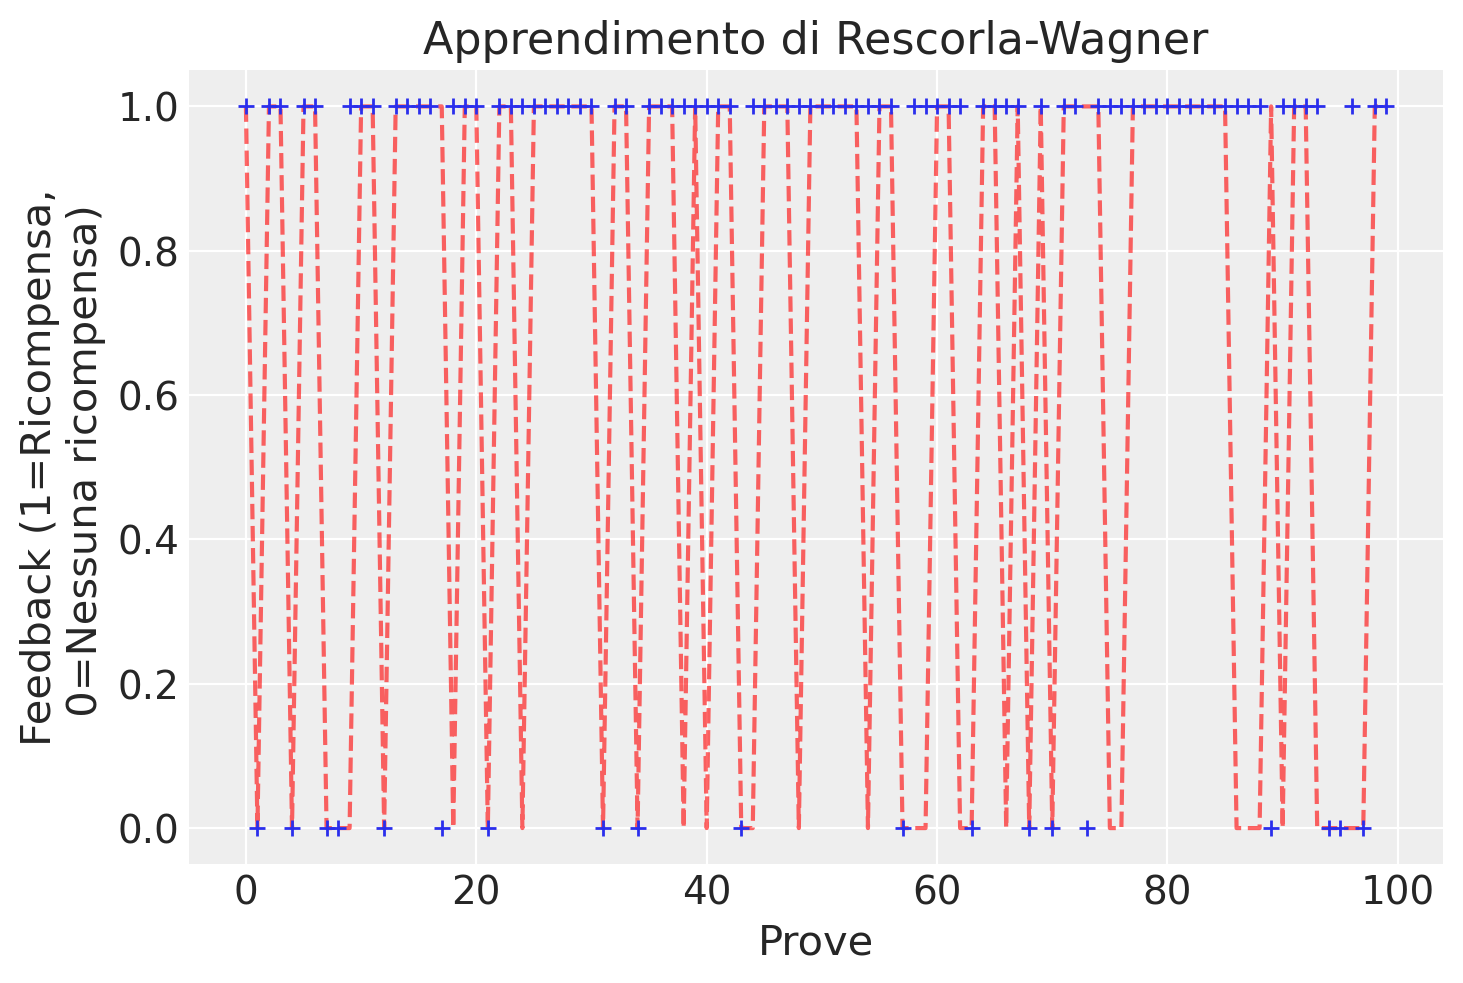

In [8]:
plt.plot(range(T), r, 'r--', alpha=.6)
plt.plot(range(T), c, '+', label='scelta')
plt.xlabel('Prove')
plt.ylabel('Feedback (1=Ricompensa,\n 0=Nessuna ricompensa)')
plt.title(f'Apprendimento di Rescorla-Wagner')
plt.show()


Il grafico successivo mostra le aspettative di valore $Q$ delle due slot machine nel corso delle prove. 

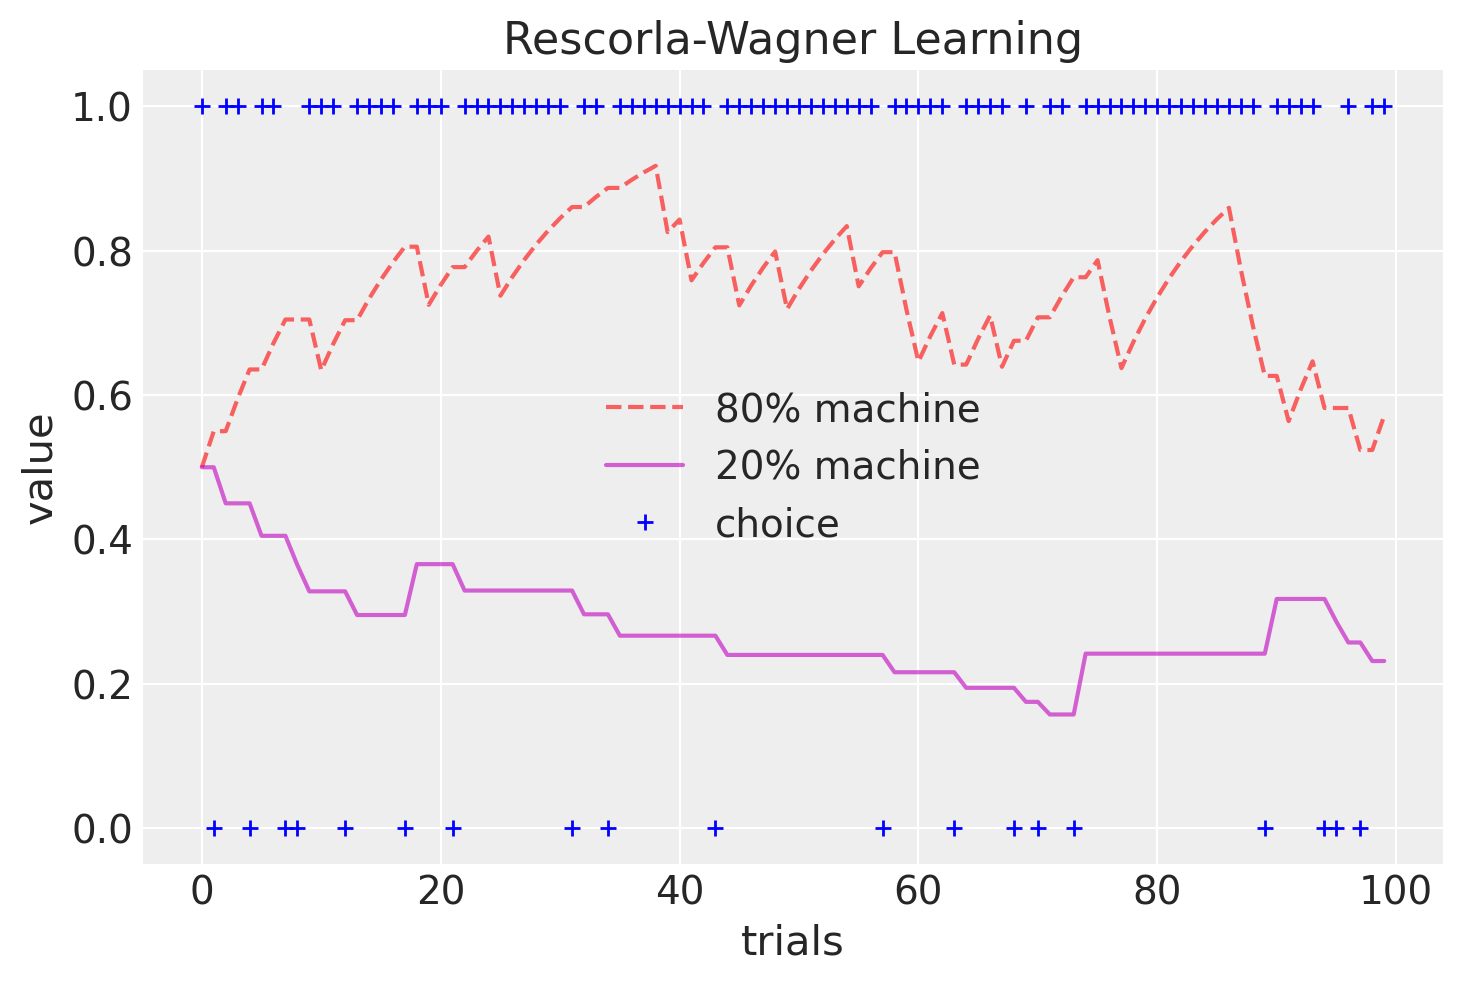

In [9]:
plt.plot(range(T), Q[1, :], 'r--', alpha=.6, label='80% machine')
plt.plot(range(T), Q[0, :], 'm-', alpha=.6, label='20% machine')
plt.plot(range(T), c, 'b+', label='choice')
plt.xlabel('trials')
plt.ylabel('value')
plt.title(f'Rescorla-Wagner Learning')
plt.legend()
plt.show()

## La Massima Verosimiglianza

Il passo successivo è stimare i parametri del modello a partire dai dati osservati. Esistono diversi metodi per stimare i parametri, ma in questa appendice ci concentreremo sull'approccio della *Massima Verosimiglianza*.

L'approccio della massima verosimiglianza cerca di trovare i valori dei parametri del modello che massimizzano la probabilità dei dati osservati. In altre parole, vogliamo trovare i parametri $(\alpha, \theta)$ che rendono i dati osservati $d_{1:T}$ più probabili secondo il modello Rescorla-Wagner.

### Calcolo del Logaritmo della Verosimiglianza

Massimizzare la verosimiglianza è spesso più facile se si lavora con il logaritmo della verosimiglianza, perché le moltiplicazioni di probabilità diventano somme. La log-verosimiglianza può essere espressa come:

$$ 
\log \mathcal{L} = \log p(d_{1:T} | (\alpha, \theta)_m, m) = \sum_{t=1}^T \log p(c_t | d_{1:t-1}, s_t, (\alpha, \theta)_m, m)
$$

In questa equazione:

- $\log \mathcal{L}$ è il logaritmo della verosimiglianza.
- $p(d_{1:T} | (\alpha, \theta)_m, m)$ è la probabilità dei dati osservati dato il modello e i parametri.
- $p(c_t | d_{1:t-1}, s_t, (\alpha, \theta)_m, m)$ è la probabilità di ogni singola scelta $c_t$ data la storia delle scelte e dei feedback fino al tempo $t$ e i parametri del modello.

### Minimizzazione del Logaritmo Negativo della Verosimiglianza

In pratica, massimizzare la log-verosimiglianza è equivalente a minimizzare il logaritmo negativo della verosimiglianza. Questo ci porta alla seguente equazione:

$$ 
-\log \mathcal{L} = -\sum_{t=1}^T \log p(c_t | d_{1:t-1}, s_t, (\alpha, \theta)_m, m)
$$

Per applicare questa procedura al modello di Rescorla-Wagner, dobbiamo definire la funzione di log-verosimiglianza negativa specifica per il nostro modello. Questa funzione ci permette di calcolare quanto bene i parametri $\alpha$ e $\theta$ spiegano i dati osservati. Durante il processo di stima, l'obiettivo è minimizzare questa funzione per trovare i valori ottimali dei parametri.

### Esempio Pratico

Immaginiamo di avere dati osservati da un esperimento in cui un partecipante ha fatto 100 scelte tra due slot machine. Il nostro obiettivo è stimare i parametri $\alpha$ (tasso di apprendimento) e $\theta$ (temperatura) che meglio spiegano queste scelte. Per fare ciò, utilizziamo il metodo della massima verosimiglianza.

La seguente funzione `negll_RescorlaWagner` calcola il negativo della log-verosimiglianza per il modello di apprendimento di Rescorla-Wagner. Questo ci permette di capire quanto bene i parametri del modello ($\alpha$ e $\theta$) spiegano le scelte osservate. Ecco una spiegazione passo passo per capire come funziona questa funzione.

I parametri della Funzione sono:

- `params`: una lista che contiene i valori dei parametri $\alpha$ (tasso di apprendimento) e $\theta$ (temperatura).
- `c`: un array che contiene le scelte effettuate dal partecipante (0 o 1).
- `r`: un array che contiene le ricompense ricevute dopo ogni scelta (1 per ricompensa, 0 per nessuna ricompensa).

Esaminiamo ora il corpo della funzione.

1. **Inizializzazione dei Parametri**

    ```python
    alpha, theta = params
    Q = [0.5, 0.5]
    T = len(c)
    choiceProb = np.zeros((T), dtype=float)
    ```

    - `alpha` e `theta` sono estratti dalla lista `params`.
    - `Q` è una lista che tiene traccia delle aspettative di valore per le due slot machine, inizializzate a 0.5.
    - `T` è il numero di scelte effettuate.
    - `choiceProb` è un array che memorizza la probabilità di ogni scelta effettuata.

2. **Calcolo delle Probabilità di Scelta e Aggiornamento dei Valori**

    ```python
    for t in range(T):
        p0 = np.exp(theta * Q[0]) / (np.exp(theta * Q[0]) + np.exp(theta * Q[1]))
        p = [p0, 1 - p0]
        choiceProb[t] = p[c[t]]
        delta = r[t] - Q[c[t]]
        Q[c[t]] = Q[c[t]] + alpha * delta
    ```

    - **Calcolo delle Probabilità di Scelta**: 

        - `p0` è la probabilità di scegliere la prima slot machine.
        - `p` è una lista delle probabilità di scegliere ciascuna delle due slot machine.
        - `choiceProb[t]` memorizza la probabilità della scelta effettivamente fatta al tempo $t$.

    - **Aggiornamento delle Aspettative di Valore**:

        - `delta` è la differenza tra la ricompensa effettiva `r[t]` e l'aspettativa di valore `Q[c[t]]` per la scelta fatta.
        - `Q[c[t]]` viene aggiornata secondo la regola di Rescorla-Wagner: il nuovo valore atteso è il vecchio valore atteso più una frazione (determinata da $\alpha$) dell'errore di previsione.

3. **Calcolo del Negativo della Log-Verosimiglianza**

    ```python
    negLL = -np.sum(np.log(choiceProb))
    return negLL
    ```

    - **Log-Verosimiglianza**:

        - `np.log(choiceProb)` calcola il logaritmo delle probabilità di scelta.
        - `np.sum(np.log(choiceProb))` somma questi logaritmi.

    - **Negativo della Log-Verosimiglianza**:
    
        - Il risultato è moltiplicato per -1 per ottenere il negativo della log-verosimiglianza, poiché nella stima dei parametri cerchiamo di minimizzare questa funzione.

In sintesi, la funzione `negll_RescorlaWagner`:

1. Calcola le probabilità di scelta basate sui parametri $\alpha$ e $\theta$.
2. Aggiorna le aspettative di valore in base alle scelte e alle ricompense osservate.
3. Calcola il negativo della log-verosimiglianza per valutare quanto bene i parametri spiegano i dati osservati.

Ecco la funzione completa con commenti per facilitarne la comprensione:

In [10]:
def negll_RescorlaWagner(params, c, r):
    alpha, theta = params
    Q = [0.5, 0.5]
    T = len(c)
    choiceProb = np.zeros((T), dtype=float)

    for t in range(T):
        # Calcola le probabilità di scelta per k = 2
        p0 = np.exp(theta * Q[0]) / (np.exp(theta * Q[0]) + np.exp(theta * Q[1]))
        # "p" è una lista di probabilità di scelta per le due opzioni disponibili
        p = [p0, 1 - p0]

        # Memorizza la probabilità della scelta effettuata
        choiceProb[t] = p[c[t]]

        # Aggiorna le aspettative di valore secondo la regola di Rescorla-Wagner
        delta = r[t] - Q[c[t]]
        Q[c[t]] = Q[c[t]] + alpha * delta

    # Calcola il negativo della log-verosimiglianza
    negLL = -np.sum(np.log(choiceProb))

    return negLL

Simuliamo ora un set di dati.

In [11]:
# simulate choices from RW Model
alpha = .2
theta = 1.5
c, r, Q2 = simulate_RescorlaWagner([alpha, theta], T=T, mu=[.2, .8])

Per fare un esempio, valutiamo la log-verosimiglianza negativa per i dati simulati in corrispondenza dei valori `alpha` e `theta` indicati di seguito.

In [12]:
alpha_hat = 0.3
theta_hat = 2.5
negLL = negll_RescorlaWagner([alpha_hat, theta_hat], c, r)
print(alpha_hat, theta_hat, negLL)

0.3 2.5 67.02432583559954


In [13]:
alpha_hat = 0.2
theta_hat = 1.5
negLL = negll_RescorlaWagner([alpha_hat, theta_hat], c, r)
print(alpha_hat, theta_hat, negLL)

0.2 1.5 62.40238018291291


Un metodo per trovare i parametri di massima verosimiglianza è effettuare una ricerca esaustiva su tutto lo spazio dei parametri. Questo significa selezionare i valori di `alpha` e `theta` per i quali la funzione `negLL` assume il valore più basso.

Per illustrare questo metodo, applichiamolo a un set di dati simulato. Per semplicità, assumiamo di conoscere il valore di $\theta$ e di dover trovare solo il valore di $\alpha$.

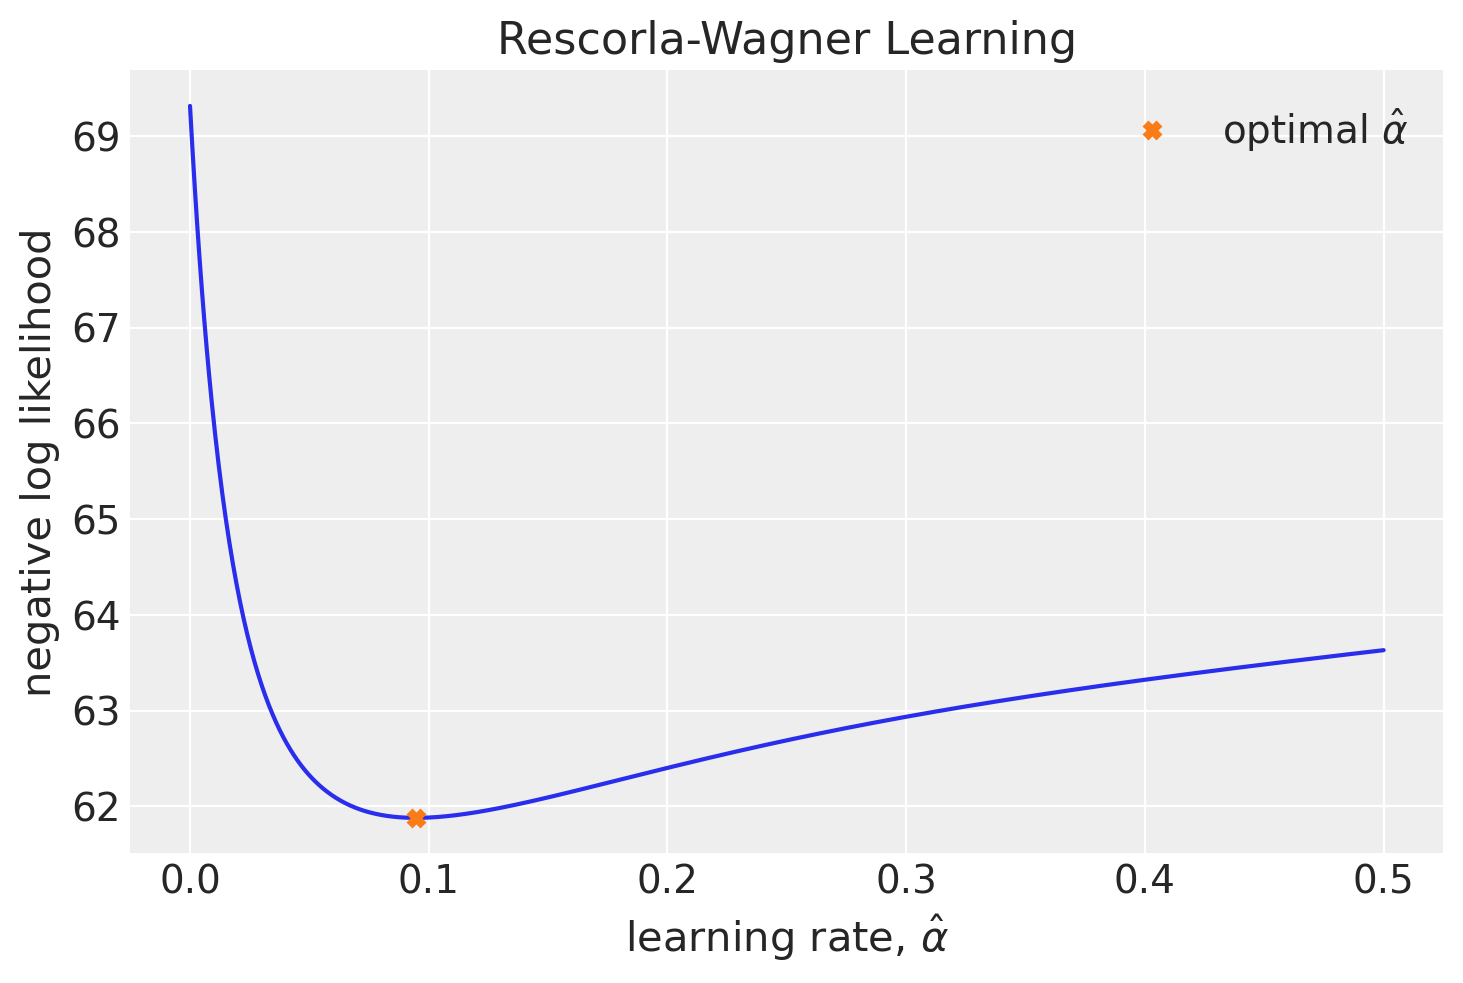

In [14]:
nLL = []
alpha_vals = np.linspace(0, 0.5, 1000)
for alpha_val in alpha_vals:
    nLL.append(negll_RescorlaWagner([alpha_val, theta], c, r))

plt.figure()
plt.plot(alpha_vals, nLL, '-')
plt.plot(
    alpha_vals[np.argmin(nLL)], nLL[np.argmin(nLL)],
    'X', label=r'optimal $\hat \alpha$'
)
plt.ylabel('negative log likelihood')
plt.xlabel(fr'learning rate, $\hat \alpha$')
plt.title(f'Rescorla-Wagner Learning')
plt.legend()
plt.show()

### Validazione

Una volta stabilito un metodo per stimare i parametri del modello dai dati, dobbiamo valutare quanto accuratamente queste stime riflettano i veri valori dei parametri del modello. Per rispondere a questa domanda, possiamo condurre uno studio di simulazione.

I parametri della simulazione sono i seguenti.

In [15]:
T = 250
mu = [0.2, 0.8]
num_subjects = 20

Calcolimo i valori di massima verosimiglianza dei parametri `alpha` e `theta` usando la funzione `minimize` per minimizzare la funzione di log-verosimiglianza. Simuliamo i dati di un soggetto.

Specifichiamo poi le stime iniziali per i valori dei parametri e i valori margine delle possibili soluzioni. I risultati saranno salvati nell'oggetto `result`. Le stime dei due parametri si estraggono con `result.x`.

In [16]:
c, r, Q = simulate_RescorlaWagner([0.15, 1.5], T=T, mu=mu)

init_guess = (0.1, 0.1)

# minimize neg LL
result = minimize(
    negll_RescorlaWagner,
    init_guess,
    (c, r),
    bounds=((0, 1), (0, 10)),
)
print(result.x)

[0.1093135  1.27704408]


Simuliamo i dati per 500 soggetti, con 250 osservazioni ciascuno, utilizzando valori casuali di `alpha` e `theta`. Successivamente, eseguiamo la stima di massima verosimiglianza per i dati di ogni soggetto, inizializzando casualmente i parametri per ciascuno di essi. Infine, salviamo i risultati ottenuti nel DataFrame `df`. Ecco il codice corrispondente:

In [17]:
NREP = 500
df = pd.DataFrame(
    index=range(0, NREP), columns=["true_alpha", "alpha", "true_theta", "theta"]
)

# loop through subjects
for index in range(NREP):

    true_alpha = 0.95 * np.random.random()
    true_theta = 4.0 * np.random.random()

    c, r, Q = simulate_RescorlaWagner([true_alpha, true_theta], T=250, mu=mu)

    init_guess = (0.2 * np.random.random(), 1.0 * np.random.random())
    # minimize neg LL
    param_fits = minimize(
        negll_RescorlaWagner,
        init_guess,
        (c, r),
        bounds=((0, 1), (0, 10)),
    )

    # store in dataframe
    df.at[index, "true_alpha"] = true_alpha
    df.at[index, "true_theta"] = true_theta
    df.at[index, "alpha"] = param_fits.x[0]
    df.at[index, "theta"] = param_fits.x[1]

La figura successiva mostra una corrispondenza tra i valori stimati di alpha e i valori veri. È importante notare che la corrispondenza non è perfetta a causa della presenza di una componente di casualità nei dati. Inoltre, in alcuni casi si possono osservare valori stimati di alpha pari a 0 o 1, che corrispondono a risultati spurii dell'algoritmo. Il numero di risultati spurii aumenta con il diminuire del numero di osservazioni per ciascun soggetto.

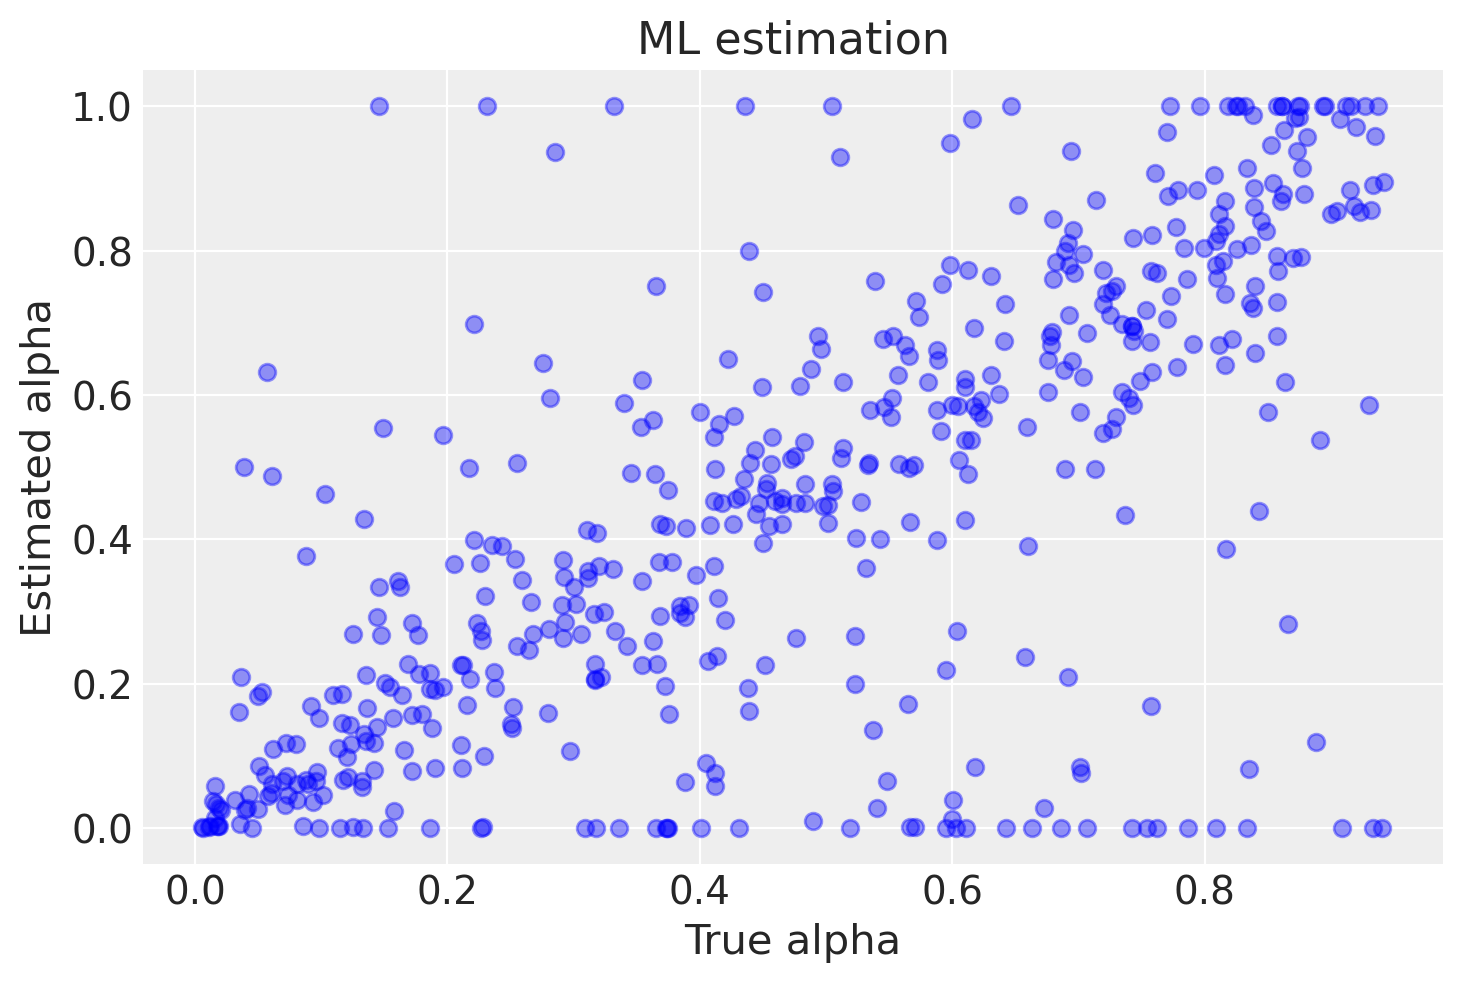

In [18]:
plt.plot(df.true_alpha, df.alpha, 'ob', alpha=.4)
plt.xlabel('True alpha')
plt.ylabel('Estimated alpha')
plt.title(f'ML estimation')
plt.show()

Un discorso analogo si può fare per theta, anche se in questo caso vi è una migliore corrispondenza tra i valori stimati e i valori veri.

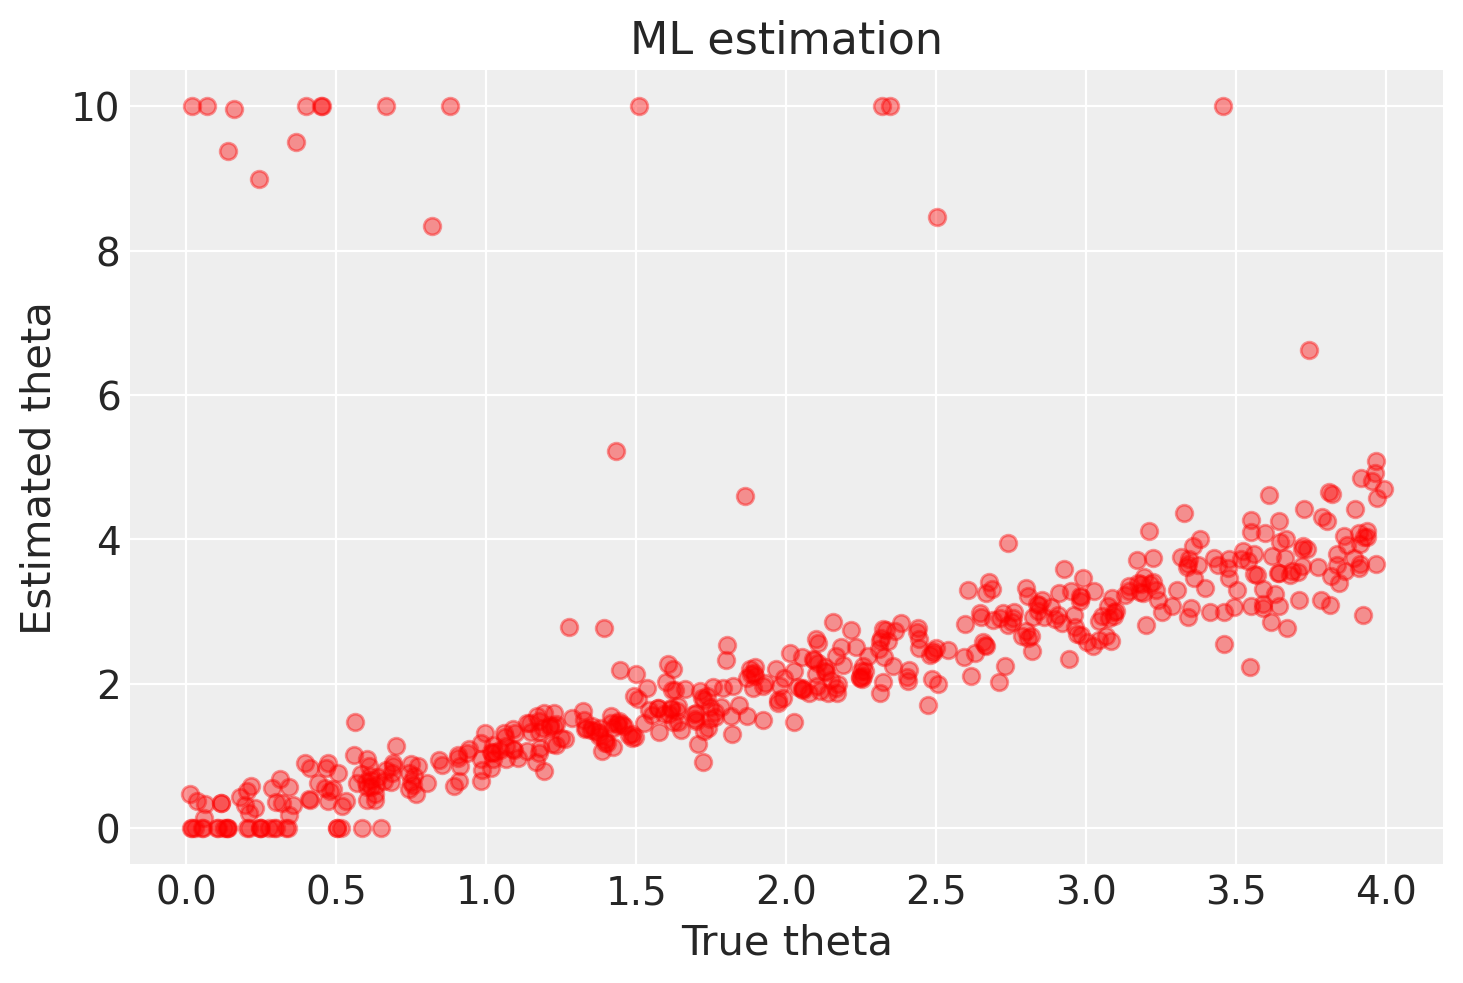

In [19]:
plt.plot(df.true_theta, df.theta, 'or', alpha=.4)
plt.xlabel('True theta')
plt.ylabel('Estimated theta')
plt.title(f'ML estimation')
plt.show()

In sintesi, possiamo affermare che il metodo della massima verosimiglianza è in grado di recuperare i valori simulati dei parametri $\alpha$ e $\theta$ del modello di Rescorla-Wagner, ma solo quando il numero di osservazioni per soggetto è considerevole. Tuttavia, è importante notare che questo metodo può produrre risultati imprecisi in determinate circostanze.

Esistono altri metodi di stima che offrono risultati migliori anche con un numero inferiore di osservazioni per soggetto. Tra questi, il metodo gerarchico bayesiano è ampiamente utilizzato nella pratica. Va precisato che l'obiettivo di questo tutorial era principalmente illustrare in modo semplice come sia possibile ottenere con buona accuratezza i parametri del modello di Rescorla-Wagner dai dati generati da una simulazione, considerando condizioni ottimali in cui i valori dei parametri del modello sono noti.

È importante sottolineare che, nella pratica, la stima dei parametri può essere un processo complesso e che l'accuratezza delle stime dipende da molteplici fattori, come la dimensione del campione e la natura dei dati osservati. Pertanto, è sempre consigliabile valutare attentamente i risultati e considerare l'utilizzo di approcci più sofisticati, come il metodo gerarchico bayesiano, per ottenere stime più affidabili dei parametri del modello.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [28]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Fri Jul 26 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

arviz     : 0.18.0
scipy     : 1.14.0
pandas    : 2.2.2
matplotlib: 3.9.1
numpy     : 1.26.4
seaborn   : 0.13.2

Watermark: 2.4.3

